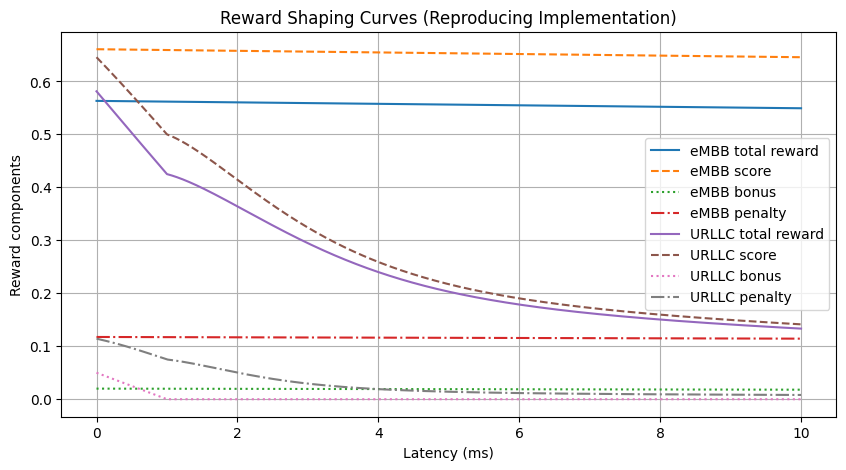

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Parameters from your implementation
# ---------------------------------------------------------
latency_target = {
    "eMBB": 0.1,     # 100 ms
    "URLLC": 0.001,  # 1 ms
}

latency_span = {
    "eMBB": 0.3,     # target * 3
    "URLLC": 0.005,  # target * 5
}

alpha = {           # logistic steepness
    "eMBB": 2.0,
    "URLLC": 3.0,
}

tail_c = {          # heavy penalty tail parameter
    "eMBB": 0.5,
    "URLLC": 0.5,
}

bonus_coeff = {
    "eMBB": 0.02,
    "URLLC": 0.05,
}

prb_penalty_coeff = {
    "eMBB": 0.3,
    "URLLC": 0.3,
}


# ---------------------------------------------------------
# Helper functions exactly matching your code
# ---------------------------------------------------------
def slice_score(latency, slice_name):
    target = latency_target[slice_name]
    span = latency_span[slice_name]
    x = (latency - target) / span

    # logistic center
    a = alpha[slice_name]
    z = max(-60, min(60, a * x))
    central = 1.0 / (1.0 + math.exp(z))

    # heavy tail
    pos = max(0.0, x)
    tail = 1.0 / (1.0 + pos / tail_c[slice_name])

    # blend
    w = pos / (1.0 + pos)
    score = (1 - w) * central + w * tail

    return np.clip(score, 1e-3, 1 - 1e-3)


def slice_bonus(latency, slice_name):
    coeff = bonus_coeff[slice_name]
    target = latency_target[slice_name]
    under = max(0.0, target - latency)
    return coeff * (under / target)


def slice_prb_penalty(prb_usage_norm, score, slice_name):
    coeff = prb_penalty_coeff[slice_name]
    # performance gate
    good_perf = 1 / (1 + math.exp(-8 * (score - 0.5)))
    return coeff * prb_usage_norm * good_perf


# ---------------------------------------------------------
# Plot reward curves for varying latency
# ---------------------------------------------------------
latencies = np.linspace(0, 0.01, 2000)  # up to 10ms
prb_usage = 0.5  # assume 50% PRB usage just for illustration

plt.figure(figsize=(10, 5))

for sl in ["eMBB", "URLLC"]:
    scores, bonuses, penalties, totals = [], [], [], []
    for L in latencies:
        s = slice_score(L, sl)
        b = slice_bonus(L, sl)
        p = slice_prb_penalty(prb_usage, s, sl)
        total = s + b - p

        scores.append(s)
        bonuses.append(b)
        penalties.append(p)
        totals.append(np.clip(total, 0, 1))

    plt.plot(latencies * 1000, totals, label=f"{sl} total reward")
    plt.plot(latencies * 1000, scores, "--", label=f"{sl} score")
    plt.plot(latencies * 1000, bonuses, ":", label=f"{sl} bonus")
    plt.plot(latencies * 1000, penalties, "-.", label=f"{sl} penalty")

plt.xlabel("Latency (ms)")
plt.ylabel("Reward components")
plt.title("Reward Shaping Curves (Reproducing Implementation)")
plt.legend()
plt.grid(True)
plt.show()
